Now that we have gone through a manual process of modeling our dataset, let's see if we can replicate this using an Automated workflow. As a reminder, our plan of action was as follows:

1. Perform EDA on the dataset to extract valuable insight about the process generating the time series **(COMPLETED)**.
2. Build a baseline model (univariable model without exogenous variables) for benchmarking purposes **(COMPLETED)**.
3. Build a univariate model with all exogenous variables to check best possible performance **(COMPLETED)**.
4. Evaluate the model with exogenous variables and discuss any potential issues **(COMPLETED)**.
5. Overcome issues identified above **(COMPLETED)**.
6. Make future predictions with the best model **(COMPLETED)**.
7. Replicate flow with Automated Time Series Modeling (AutoML) **(Covered in this notebook)**

In [1]:
# Only enable critical logging (Optional)
import os
os.environ["PYCARET_CUSTOM_LOGGING_LEVEL"] = "CRITICAL"

In [2]:
def what_is_installed():
    from pycaret import show_versions
    show_versions()

try:
    what_is_installed()
except ModuleNotFoundError:
    !pip install pycaret
    what_is_installed()


System:
    python: 3.9.16 (main, Jan 11 2023, 16:16:36) [MSC v.1916 64 bit (AMD64)]
executable: C:\Users\Nikhil\.conda\envs\pycaret_dev_sktime_16p1\python.exe
   machine: Windows-10-10.0.19044-SP0

PyCaret required dependencies:
                 pip: 22.3.1
          setuptools: 65.6.3
             pycaret: 3.0.0rc9
             IPython: 8.10.0
          ipywidgets: 8.0.4
                tqdm: 4.64.1
               numpy: 1.23.5
              pandas: 1.5.3
              jinja2: 3.1.2
               scipy: 1.10.0
              joblib: 1.2.0
             sklearn: 1.2.1
                pyod: 1.0.8
            imblearn: 0.10.1
   category_encoders: 2.6.0
            lightgbm: 3.3.5
               numba: 0.56.4
            requests: 2.28.2
          matplotlib: 3.7.0
          scikitplot: 0.3.7
         yellowbrick: 1.5
              plotly: 5.13.0
             kaleido: 0.2.1
         statsmodels: 0.13.5
              sktime: 0.16.1
               tbats: 1.1.2
            pmdarima: 2.0.2


In [3]:
import numpy as np
import pandas as pd
from pycaret.datasets import get_data
from pycaret.time_series import TSForecastingExperiment

In [4]:
# Global Figure Settings for notebook ----
# Depending on whether you are using jupyter notebook, jupyter lab, Google Colab, you may have to set the renderer appropriately
# NOTE: Setting to a static renderer here so that the notebook saved size is reduced.
global_fig_settings = {
    # "renderer": "notebook",
    "renderer": "png",
    "width": 1000,
    "height": 600,
}

In [5]:
data = get_data("airquality", verbose=False)

# Limiting the data for demonstration purposes.
data = data.iloc[-720:]
data["index"] = pd.to_datetime(data["Date"] + " " + data["Time"])
data.drop(columns=["Date", "Time"], inplace=True)
data.replace(-200, np.nan, inplace=True)
data.set_index("index", inplace=True)

target = "CO(GT)"
exog_vars = ['NOx(GT)', 'PT08.S3(NOx)', 'RH']
include = [target] + exog_vars
data = data[include]
data.head()

,CO(GT),NOx(GT),PT08.S3(NOx),RH
index,,,,
2005-03-05 15:00:00,1.5,180.0,820.0,28.3
2005-03-05 16:00:00,1.8,255.0,751.0,29.7
2005-03-05 17:00:00,2.0,251.0,721.0,38.7
2005-03-05 18:00:00,1.9,258.0,695.0,56.3
2005-03-05 19:00:00,2.5,344.0,654.0,57.9


# Step 7: AutoML

In [6]:
FH=48
metric = "mase"
exclude = ["auto_arima", "bats", "tbats", "lar_cds_dt", "par_cds_dt"]

# Step 7A: Univariate AutoML with and without Exogenous Variables

In [7]:
exp_auto = TSForecastingExperiment()

# enforce_exogenous=False --> Use multivariate forecasting when model supports it, else use univariate forecasting
exp_auto.setup(
    data=data, target=target, fh=FH, enforce_exogenous=False,
    numeric_imputation_target="ffill", numeric_imputation_exogenous="ffill",
    fig_kwargs=global_fig_settings, session_id=42
)

,Description,Value
0,session_id,42
1,Target,CO(GT)
2,Approach,Univariate
3,Exogenous Variables,Present
4,Original data shape,"(720, 4)"
5,Transformed data shape,"(720, 4)"
6,Transformed train set shape,"(672, 4)"
7,Transformed test set shape,"(48, 4)"
8,Rows with missing values,3.8%
9,Fold Generator,ExpandingWindowSplitter


In [8]:
# # Check available models ----
# exp_auto_noexo.models()

In [9]:
# Include slower models like Prophet (turbo=False), but exclude some specific models ----
best = exp_auto.compare_models(sort=metric, turbo=False, exclude=exclude)

,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2,TT (Sec)
arima,ARIMA,0.2509,0.2302,0.1810,0.2449,0.1443,0.1523,0.8499,0.9367
prophet,Prophet,0.3079,0.2647,0.2226,0.2823,0.1943,0.2027,0.8501,0.5800
br_cds_dt,Bayesian Ridge w/ Cond. Deseasonalize & Detrending,0.8609,0.8199,0.6211,0.8730,0.4675,0.4450,-0.7053,1.1967
ridge_cds_dt,Ridge w/ Cond. Deseasonalize & Detrending,0.8647,0.8218,0.6238,0.8750,0.4714,0.4491,-0.7106,1.2200
lr_cds_dt,Linear w/ Cond. Deseasonalize & Detrending,0.8651,0.8220,0.6240,0.8752,0.4718,0.4494,-0.7111,1.4067
snaive,Seasonal Naive Forecaster,0.9672,0.9659,0.6972,1.0275,0.4645,0.3643,-1.8616,1.3867
theta,Theta Forecaster,0.9871,0.8962,0.7146,0.9574,0.4639,0.4412,-0.2349,0.0600
en_cds_dt,Elastic Net w/ Cond. Deseasonalize & Detrending,0.9948,0.9519,0.7181,1.0130,0.5099,0.3702,-1.7375,1.3767
lasso_cds_dt,Lasso w/ Cond. Deseasonalize & Detrending,1.0081,0.9598,0.7275,1.0213,0.5178,0.3741,-1.8353,1.1533
llar_cds_dt,Lasso Least Angular Regressor w/ Cond. Deseasonalize & Detrending,1.0081,0.9598,0.7275,1.0213,0.5178,0.3741,-1.8354,1.1967


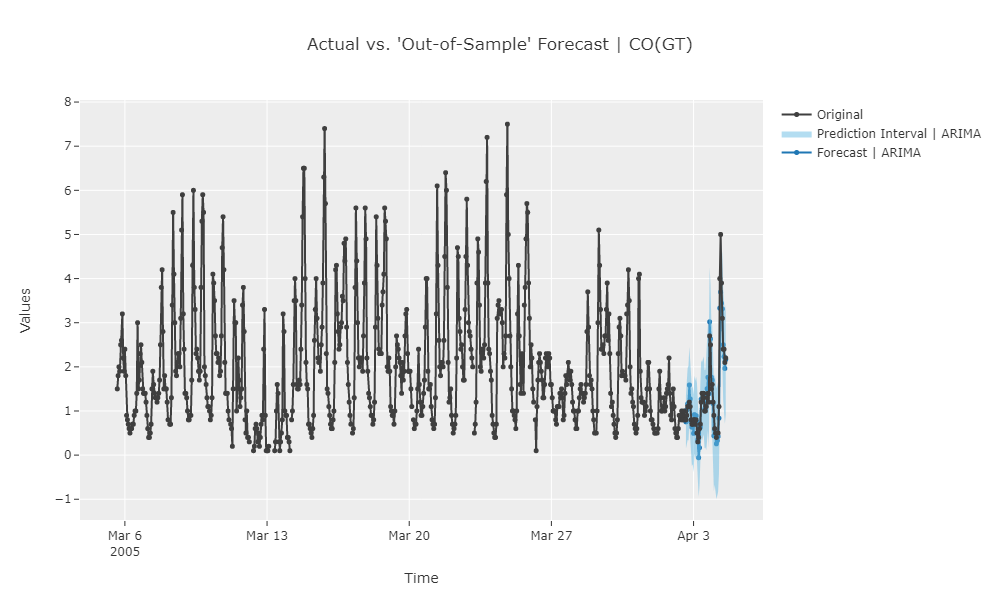

In [10]:
exp_auto.plot_model(best)

In [11]:
final_auto_model = exp_auto.finalize_model(best)

In [12]:
def safe_predict(exp, model):
    """Prediction wrapper for demo purposes."""
    try: 
        future_preds = exp.predict_model(model)
    except ValueError as exception:
        print(exception)
        exo_vars = exp.exogenous_variables
        print(f"{len(exo_vars)} exogenous variables (X) needed in order to make future predictions:\n{exo_vars}")
        
        
        exog_exps = []
        exog_models = []
        for exog_var in exog_vars:
            exog_exp = TSForecastingExperiment()
            exog_exp.setup(
                data=data[exog_var], fh=FH,
                numeric_imputation_target="ffill", numeric_imputation_exogenous="ffill",
                fig_kwargs=global_fig_settings, session_id=42
            )

            # Users can customize how to model future exogenous variables i.e. add
            # more steps and models to potentially get better models at the expense
            # of higher modeling time.
            best = exog_exp.compare_models(
                sort=metric, include=["arima", "ets", "exp_smooth", "theta", "lightgbm_cds_dt",]        
            )
            final_exog_model = exog_exp.finalize_model(best)

            exog_exps.append(exog_exp)
            exog_models.append(final_exog_model)

        # Step 2: Get future predictions for exog variables ----
        future_exog = [
            exog_exp.predict_model(exog_model)
            for exog_exp, exog_model in zip(exog_exps, exog_models)
        ]
        future_exog = pd.concat(future_exog, axis=1)
        future_exog.columns = exog_vars
        
        future_preds = exp.predict_model(model, X=future_exog)
    
    return future_preds      

Model was trained with exogenous variables but you have not passed any for predictions. Please pass exogenous variables to make predictions.
3 exogenous variables (X) needed in order to make future predictions:
['NOx(GT)', 'PT08.S3(NOx)', 'RH']


,Description,Value
0,session_id,42
1,Target,NOx(GT)
2,Approach,Univariate
3,Exogenous Variables,Not Present
4,Original data shape,"(720, 1)"
5,Transformed data shape,"(720, 1)"
6,Transformed train set shape,"(672, 1)"
7,Transformed test set shape,"(48, 1)"
8,Rows with missing values,0.8%
9,Fold Generator,ExpandingWindowSplitter


,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2,TT (Sec)
arima,ARIMA,0.8406,0.9158,87.3689,133.0642,0.4273,0.3443,-1.3072,0.3200
exp_smooth,Exponential Smoothing,0.8954,0.8400,93.0132,121.9760,0.4828,0.5917,-0.9311,0.1533
theta,Theta Forecaster,1.0279,0.9437,107.4620,137.6886,0.5192,0.4990,-0.4072,0.0600
lightgbm_cds_dt,Light Gradient Boosting w/ Cond. Deseasonalize & Detrending,1.2021,1.1033,124.6215,160.1069,0.6995,0.5078,-2.5717,1.1700
ets,ETS,1.6466,1.5514,171.0757,225.4193,0.9284,0.5548,-4.3206,1.7100


,Description,Value
0,session_id,42
1,Target,PT08.S3(NOx)
2,Approach,Univariate
3,Exogenous Variables,Not Present
4,Original data shape,"(720, 1)"
5,Transformed data shape,"(720, 1)"
6,Transformed train set shape,"(672, 1)"
7,Transformed test set shape,"(48, 1)"
8,Rows with missing values,0.1%
9,Fold Generator,ExpandingWindowSplitter


,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2,TT (Sec)
exp_smooth,Exponential Smoothing,1.2435,1.2056,126.5383,158.9241,0.1738,0.1695,-0.0211,0.1600
ets,ETS,1.3630,1.3140,138.7259,173.2545,0.1906,0.1879,-0.2091,0.7067
theta,Theta Forecaster,1.3716,1.3079,139.5929,172.4272,0.1909,0.1878,-0.1963,0.0500
arima,ARIMA,1.3929,1.3245,141.6775,174.6211,0.1792,0.1953,-0.3985,0.4100
lightgbm_cds_dt,Light Gradient Boosting w/ Cond. Deseasonalize & Detrending,1.6778,1.5491,170.7442,204.2588,0.2197,0.2541,-0.7666,1.1667


,Description,Value
0,session_id,42
1,Target,RH
2,Approach,Univariate
3,Exogenous Variables,Not Present
4,Original data shape,"(720, 1)"
5,Transformed data shape,"(720, 1)"
6,Transformed train set shape,"(672, 1)"
7,Transformed test set shape,"(48, 1)"
8,Rows with missing values,0.1%
9,Fold Generator,ExpandingWindowSplitter


,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2,TT (Sec)
theta,Theta Forecaster,1.6218,1.4765,11.3749,13.1578,0.2481,0.2286,-0.0585,0.0500
arima,ARIMA,1.8001,1.6165,12.6310,14.4108,0.2548,0.2523,-0.2695,0.0800
lightgbm_cds_dt,Light Gradient Boosting w/ Cond. Deseasonalize & Detrending,2.7797,2.6115,19.4667,23.2519,0.5241,0.3609,-4.8711,0.5633
exp_smooth,Exponential Smoothing,5.2972,4.7592,37.2423,42.4918,0.7188,0.9298,-10.5261,0.1400
ets,ETS,5.3235,4.7812,37.4259,42.6872,0.7228,0.9349,-10.5911,0.1233


<Axes: >

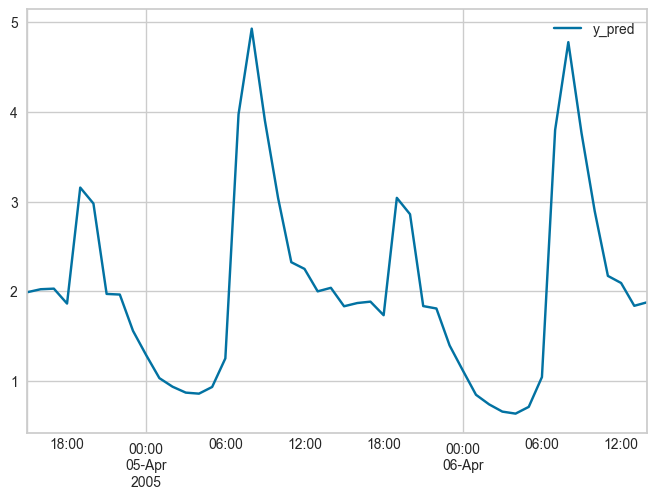

In [13]:
future_preds = safe_predict(exp_auto, final_auto_model)
future_preds.plot()